# TUTORIAL: Real-time digital twin of a hydrogen-based annular combustor
 

We can now put everything we have learned together. Data assimilation using real experimental data

We develop a digital twin of the hydrogen-based annular combustor. We want to estimate the LOM parameters and states from raw experimental data from microphones.  Because the raw data may be biased, we need to model the bias in both, measurement data and model.


In [3]:
from src.utils import set_working_directories, get_annular_data

data_folder, results_folder, figs_folder = set_working_directories('annular')
get_annular_data(data_folder) # Download the data if not already present

File 'annular_data.zip' already exists. Skipping download.
File 'README.md' already exists. Skipping download.


## 1. Load data 
Create the reference truth and the observations.

The function ```create_truth``` is a compact form of the code below
```
  
# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, y_raw, t_true = [mat[key].squeeze() for key in ['y_filtered', 'y_raw', 't']]

t_max = 7.
i1 = np.argmin(abs(t_true - t_max))
y_true, y_raw, t_true = [xx[:i1] for xx in [y_true, y_raw, t_true]]
t_true -= t_true[0]

Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]
```


In [4]:
from src.models_physical import Annular
from src.create import create_truth
import os

ER = 0.4875 + 0.025 # 0.4875 + np.arange(0, 4) * 0.025

t_start = Annular.t_transient
t_stop = t_start + Annular.t_CR * 15

truth = create_truth(model = os.path.join(data_folder, 'ER_{}'.format(ER)),
                     t_start = t_start,
                     t_stop = t_stop,
                     Nt_obs = 35,
                     t_max = t_stop + Annular.t_transient,
                     post_processed=False
                     )



The output ```truth``` is a dictionary containing
```
dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t, 
     t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t, std_obs=std_obs)
```

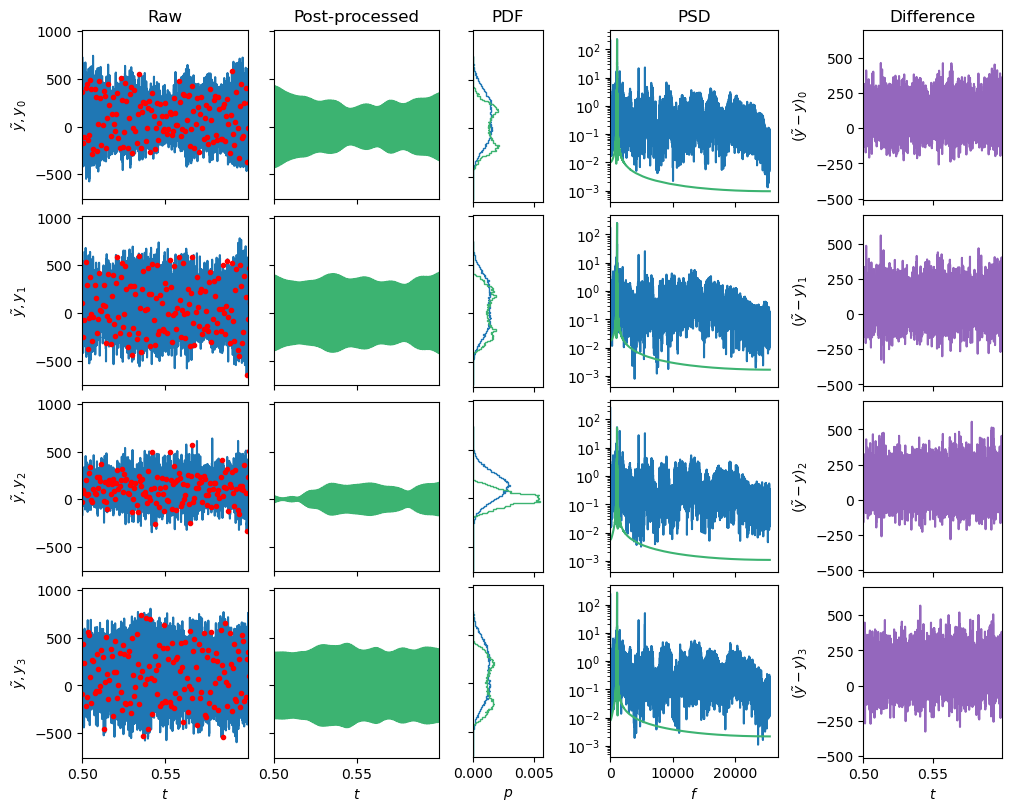

In [5]:
from src.plot_results import plot_truth
plot_truth(**truth, window=0.1)
truth_og = truth.copy()

## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The function ```create_ensemble``` consists of* 

```
alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = dict(m= 20, 
                     std_psi=0.3,
                     std_a=alpha0)

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)
ensemble.close()
```

In [6]:
from src.create import create_ensemble
import numpy as np

alpha0 = dict(nu=(-15., 30.),
              c2beta=(10, 50),
              kappa=(1.E-4, 2.E-4),
              epsilon=(5e-3, 8e-3),
              omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.4, 0.6)
              )

forecast_params = dict(model=Annular, 
                       dt=truth['dt'], 
                       m=20, 
                       std_psi=0.3, 
                       std_a=alpha0,
                       filter='rBA_EnKF',  # 'rBA_EnKF' 'EnKF' 'EnSRKF'
                       )

ensemble = create_ensemble(**forecast_params)

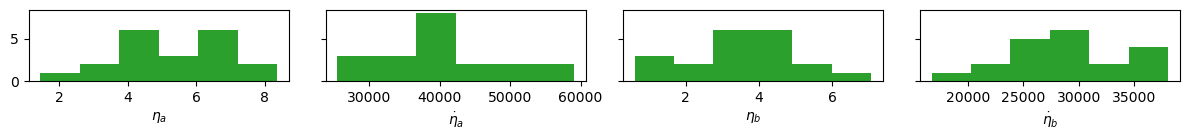

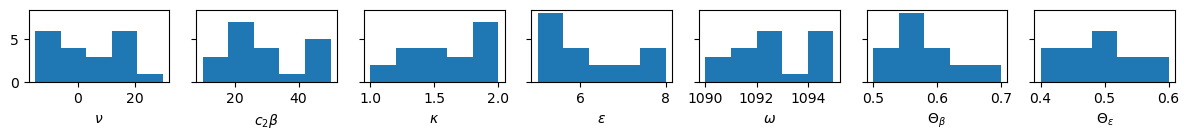

In [7]:
# Visualize ensemble initialization
from src.plot_results import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi, 'epsilon': 1e-3})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br>

**4.1. Initialise the ESN**

In [8]:
from src.bias import ESN

ensemble_ESN = ensemble.copy()

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=10,
                    t_train=ensemble.t_transient / 3.,
                    t_test=ensemble.t_CR * 2,
                    t_val=ensemble.t_CR * 2,
                    # Training data generation options
                    augment_data=True,
                    biased_observations=True,
                    correlation_based_training=True,
                    seed_W=0,
                    N_folds=4,
                    L=20,
                    std_a=alpha0,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-12, 1e-9]
                    )

ensemble_ESN.init_bias(**train_params)



**4.2 Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

```
from src.create import create_washout
wash_t, wash_obs = create_washout(ensemble.bias, t=t_true, y_raw=y_raw)
```

In [9]:
from src.utils import save_to_pickle_file, load_from_pickle_file
from src.create import create_bias_model

ESN_filename = 'ESN_case_annular_raw'
 
bias, wash_obs, wash_t = create_bias_model(ensemble,
                                            bias_params=train_params,
                                            training_dataset=truth,
                                            folder=results_folder,
                                            bias_filename=ESN_filename
                                            )


ensemble_BA = ensemble.copy()
ensemble_BA.bias = bias.copy()

Test if loaded file is valid
	 upsample 5 5
	 N_units 50 50
	 N_wash 10 10
	 t_train 0.16666666666666666 0.16666666666666666
	 t_test 0.02 0.02
	 t_val 0.02 0.02
	 augment_data True True
	 biased_observations True True
	 seed_W 0 0
	 N_folds 4 4
	 L 20 20
	 rho_range (0.5, 1.0) (0.5, 1.0)
	 sigma_in_range (-5.0, 1.0) (-5.0, 1.0)
	 tikh_range [1e-12, 1e-09] [1e-12, 1e-09]
	 noise_type Exp_ER_0.5125 Exp_ER_0.5125

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [10]:
from src.data_assimilation import dataAssimilation

out = []
DA_kwargs = dict(y_obs=truth['y_obs'].copy(), t_obs=truth['t_obs'].copy(), std_obs=0.05, 
                 wash_obs=wash_obs, wash_t=wash_t)

Nt_extra = int(ensemble.t_CR / ensemble.dt) * 10
    
ks = [0, 5.] 

for kk in ks:
    ens = ensemble_BA.copy()
    ens.regularization_factor = kk    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy(), Nt_extra=Nt_extra)
    out.append(filter_ens.copy())


 ------------------ Annular Model Parameters ------------------ 
	 c2beta = 20.880000
	 epsilon = 0.002300
	 kappa = 0.000120
	 nu = -14.505000
	 omega = 6848.671985
	 theta_b = 0.630000
	 theta_e = 0.660000

 ---------------- Bias_ESN bias model input_parameters --------------- 
	 L = 20
	 N_ens = 1
	 N_units = 50
	 N_wash = 10
	 bayesian_update = False
	 connect = 3
	 observed_idx = [4 5 6 7]
	 perform_test = True
	 rho = 0.826322
	 sigma_in = 0.012987
	 t_train = 0.166667
	 t_val = 0.02
	 tikh = 1e-09
	 update_reservoir = False
	 upsample = 5

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF 
 	 Bias = Bias_ESN 
 	 m = 20 
 	 Time steps between analysis = 35 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.002 
 	 Reject Inflation = 1.002 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (-15.0, 30.0), 'c2beta': (10, 50), 'kappa': (0.0001, 0.0002), 'epsilon': (0.005, 0.008

              c2beta       epsilon          kappa            nu            omega         theta_b        theta_e
------------  -----------  ---------------  ---------------  ------------  ------------  -------------  -------------
Truth         $20.88$      $0.0023$         $0.00012$        $-14.505$     $6848.672$    $0.63$         $0.66$
rBA_EnKF      $37.91768    $0.0060214262    $0.00016000751   $-9.9150368   $6863.81      $0.5897331     $0.48564792
 w/ Bias_ESN   \pm 7.54$    \pm 0.0007055$   \pm 2.02e-05$    \pm 3.968$    \pm 2.588$    \pm 0.03732$   \pm 0.04069$
rBA_EnKF      $22.857282   $0.005525713     $0.00020077762   $-3.4470381   $6814.133     $0.67221296    $0.2169337
 w/ Bias_ESN   \pm 5.512$   \pm 0.0005099$   \pm 2.018e-05$   \pm 1.927$    \pm 0.9834$   \pm 0.02805$   \pm 0.03365$


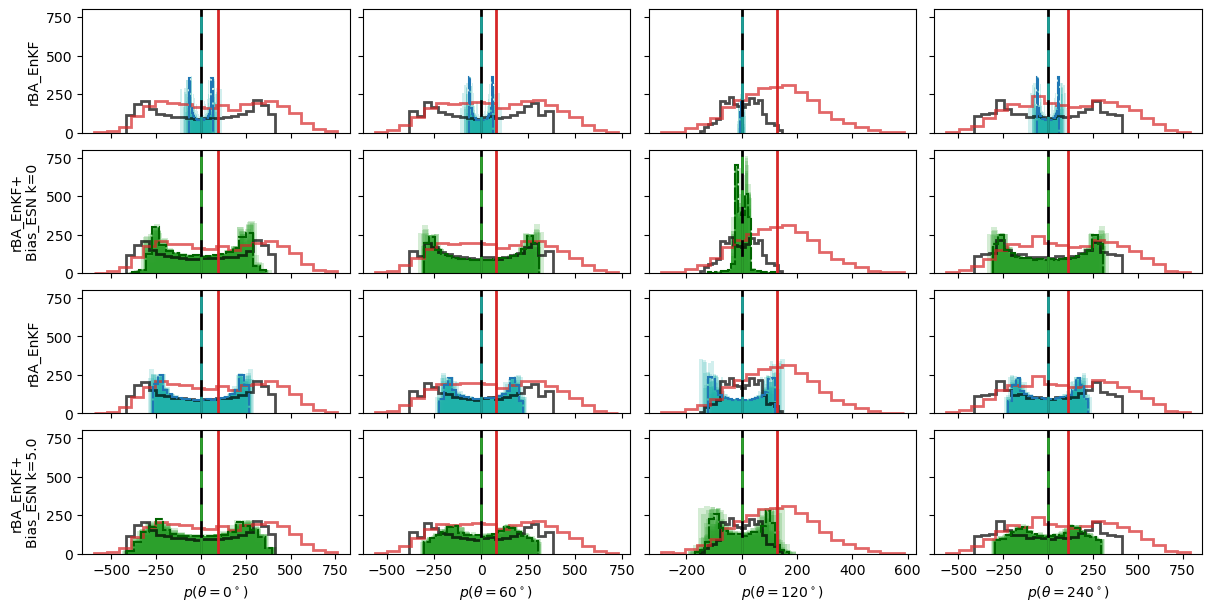

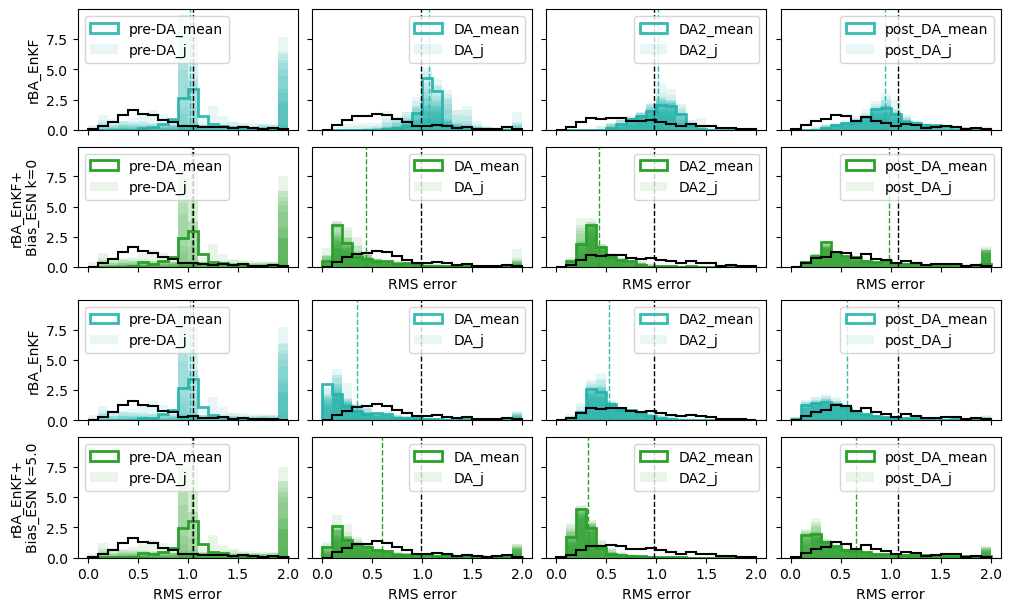

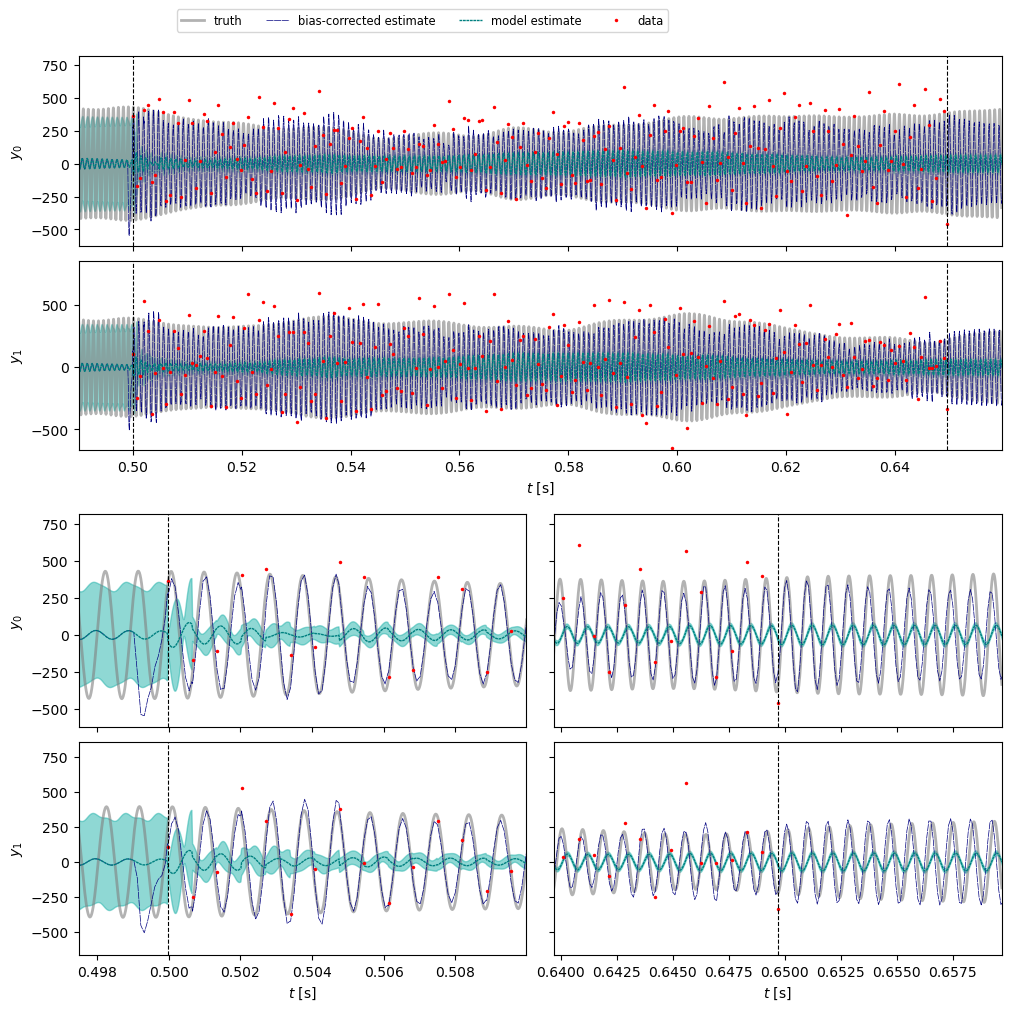

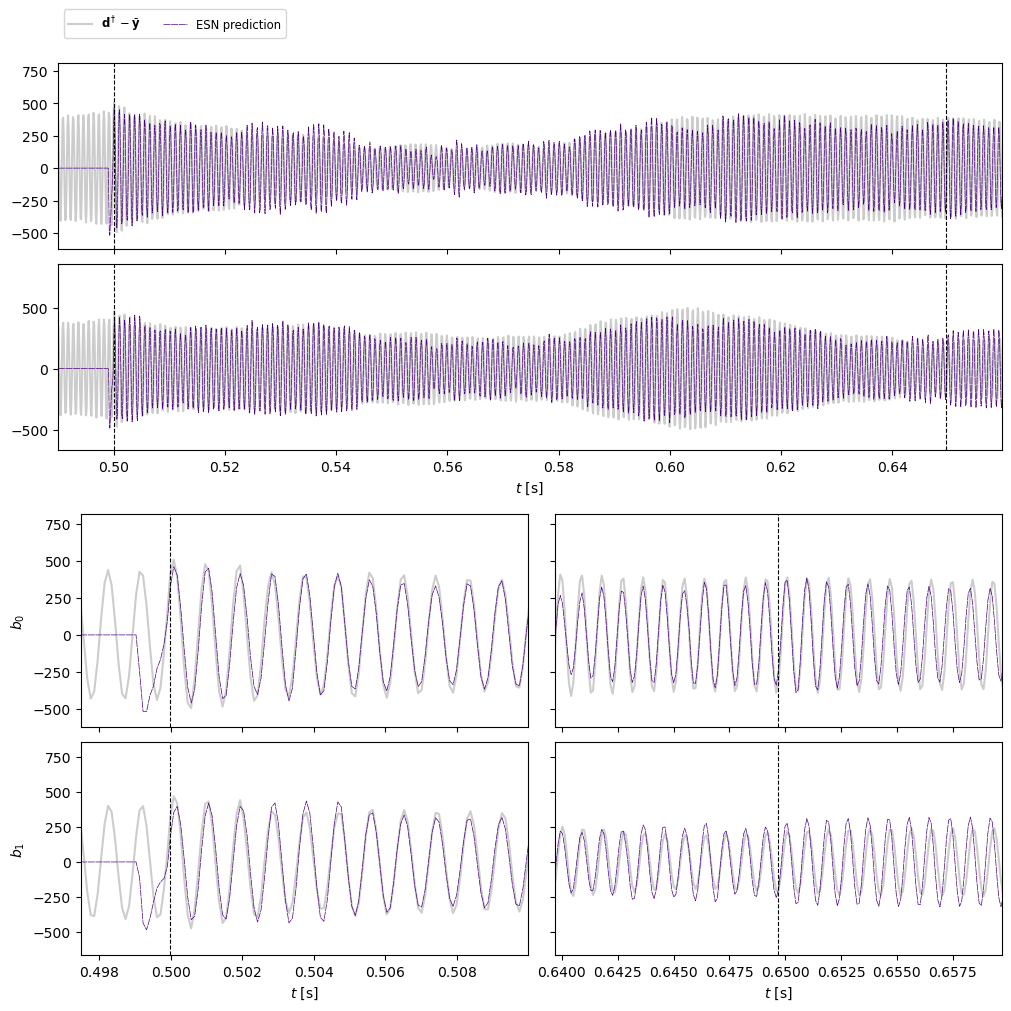

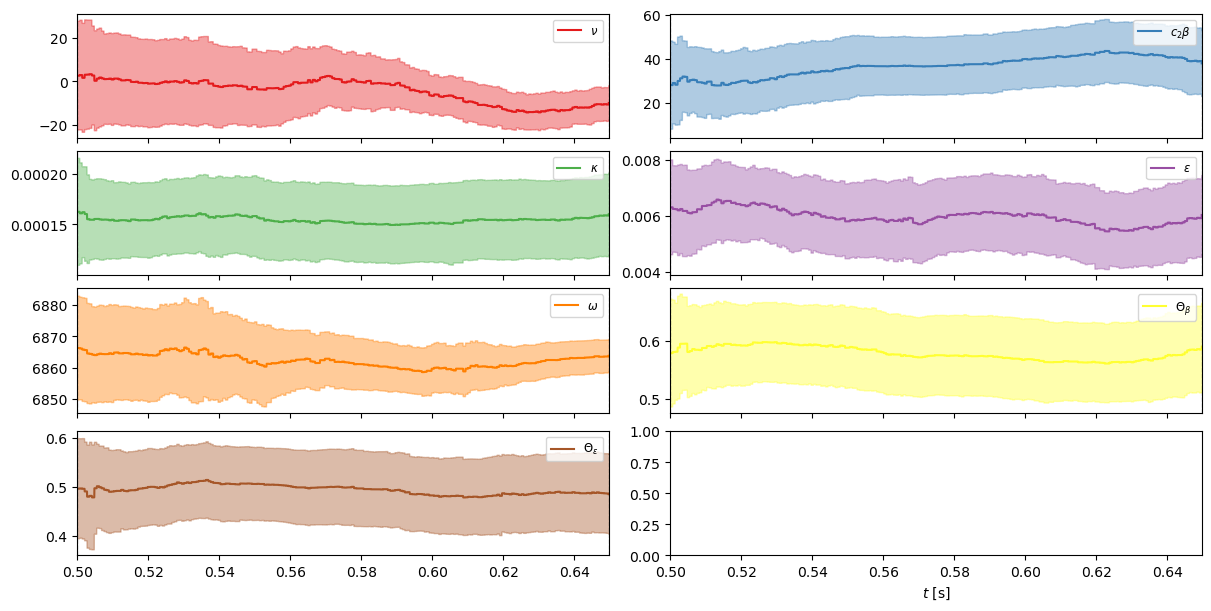

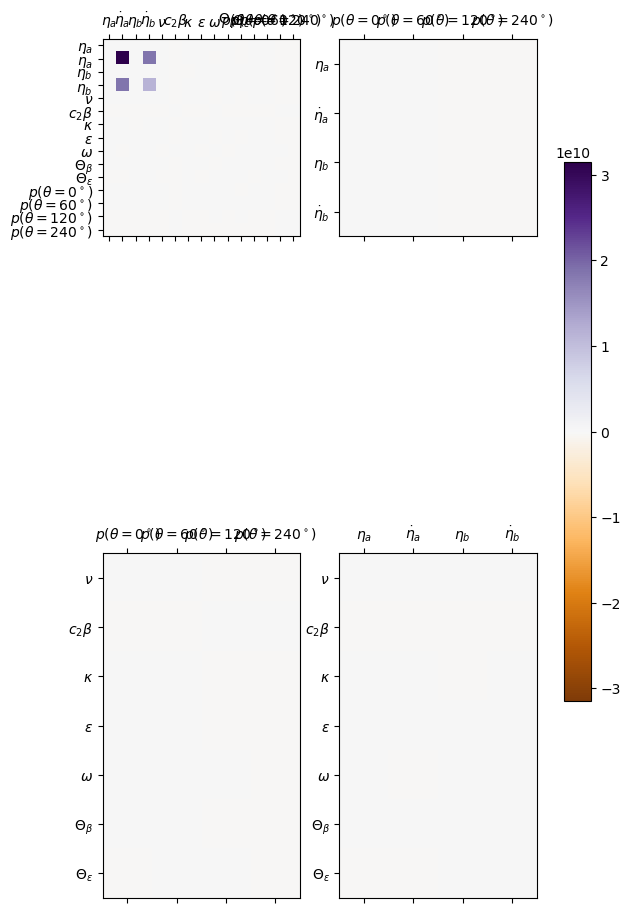

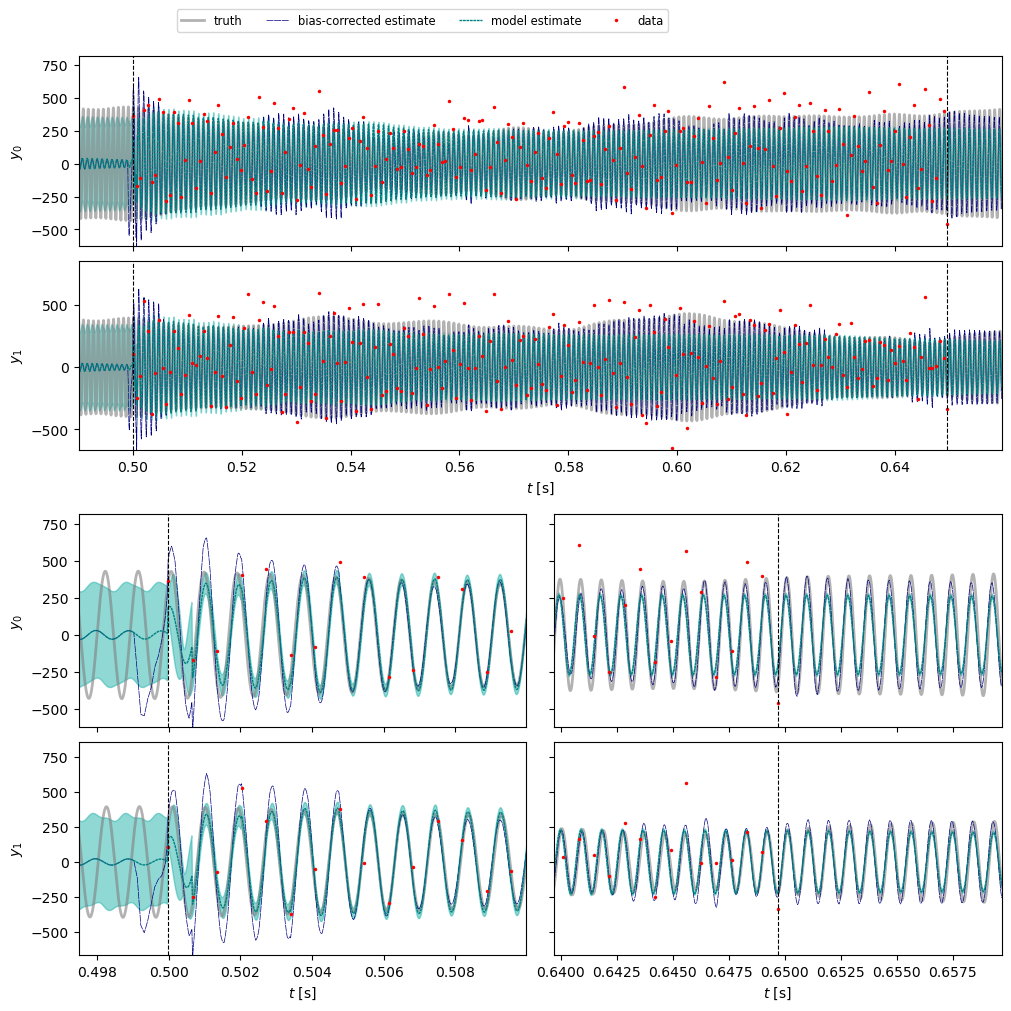

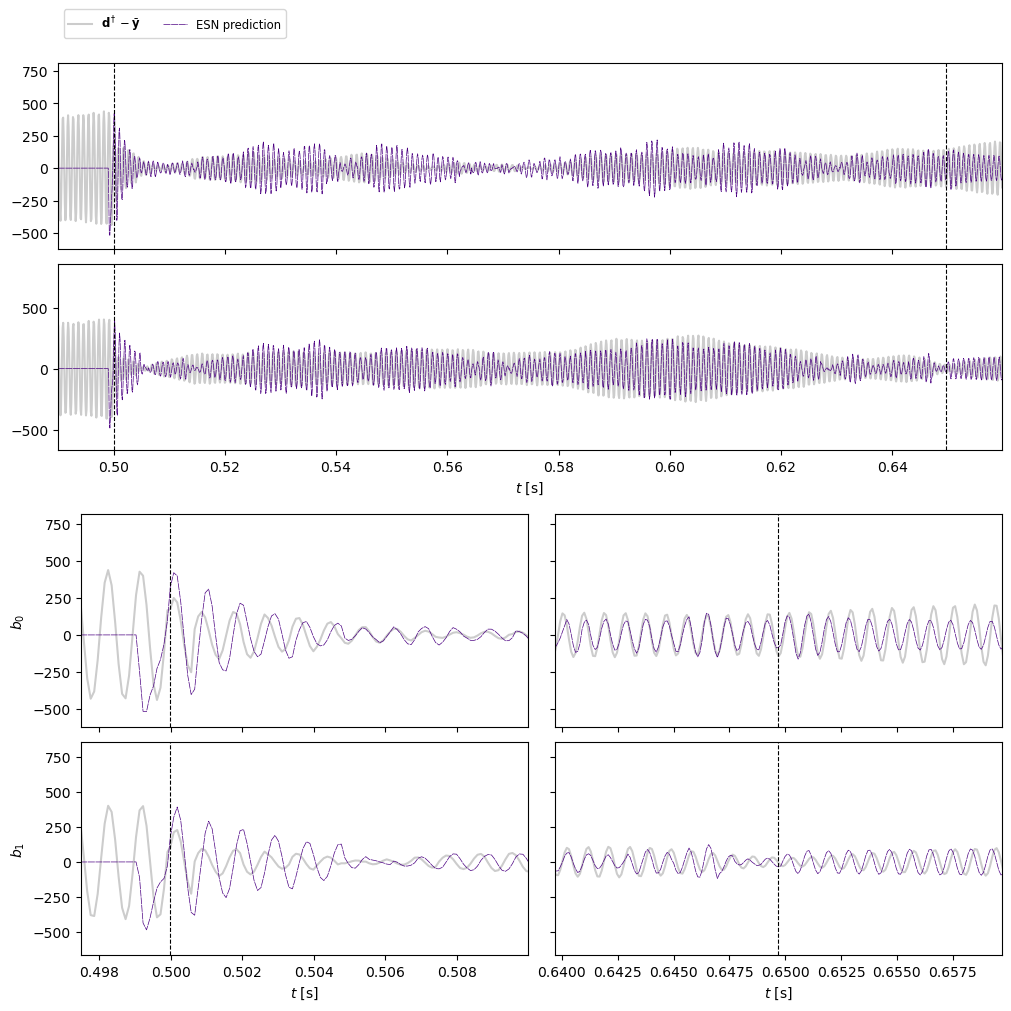

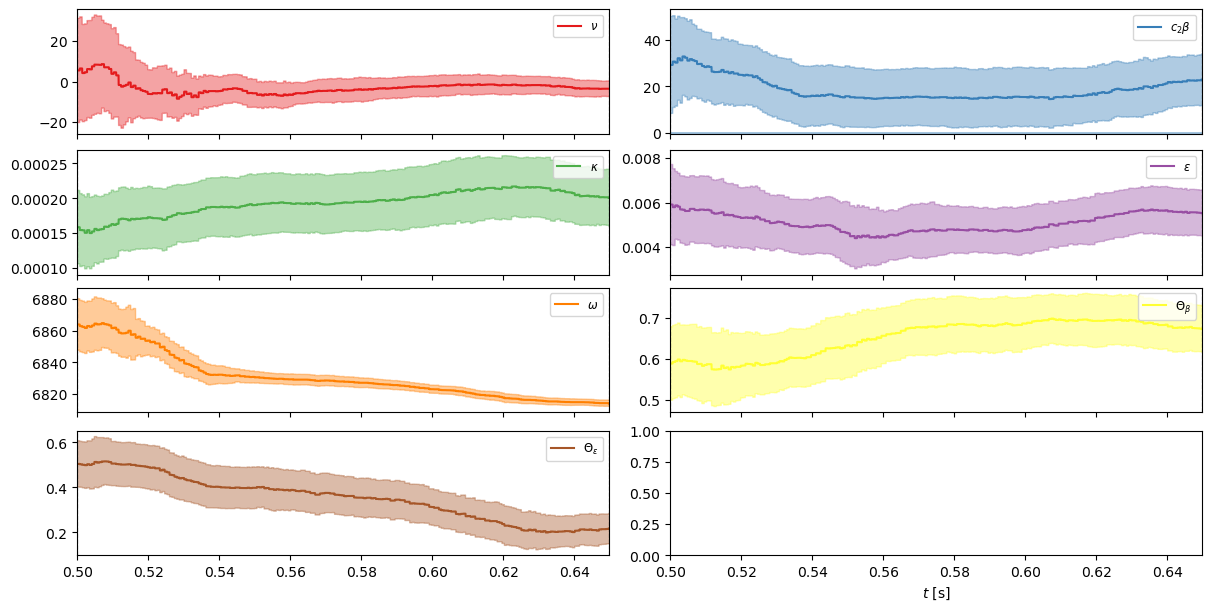

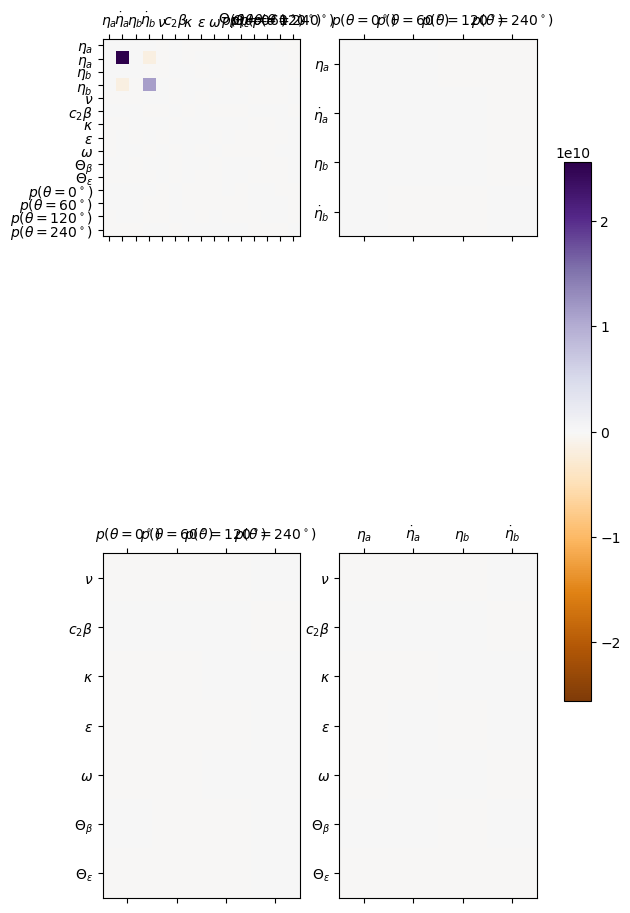

In [11]:
from src.plot_results import *

print_parameter_results(out)
plot_states_PDF(out, truth, nbins=20, window=(truth['t_obs'][-1], truth['t_obs'][-1] + ensemble.t_CR * 5))
plot_RMS_pdf(out, truth, nbins=20)

for ens in out:
    plot_timeseries(ens, truth, plot_bias=True, dims=[0,1])
    plot_parameters(ens, truth)
    plot_covariance(ens)